In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
item_to_id = pd.read_csv('/Users/ChunyanHao/desktop/github/ds_take_home/data/grocery/item_to_id.csv')
purchase_history = pd.read_csv('/Users/ChunyanHao/desktop/github/ds_take_home/data/grocery/purchase_history.csv')

In [4]:
item_to_id.head(3)

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38


In [5]:
for column in item_to_id.columns:
    uniques = item_to_id[column].unique()
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

Item_name               48	 ['coffee' 'tea' 'juice' 'soda' 'sandwich loaves']
Item_id                 48	 [43 23 38  9 39]


In [6]:
purchase_history.head(3)

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"


In [7]:
purchase_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


In [8]:
purchase_history['id'] = purchase_history.id.apply(lambda x: x.split(','))

### Question 1

The customer who bought the most items overall in her lifetime

In [9]:
purchase_history['item_count'] = purchase_history.id.apply(lambda x: len(x))

In [10]:
purchase_history.groupby(['user_id'])['item_count'].sum().reset_index().sort_values(by='item_count', ascending = False).head()

,user_id,item_count
4445,269335,72
6111,367872,70
6623,397623,64
9918,599172,64
6291,377284,63


### Question 2

For each item, the customer who bought that product the most

In [11]:
purchase_history.head()

,user_id,id,item_count
0,222087,"[27, 26]",2
1,1343649,"[6, 47, 17]",3
2,404134,"[18, 12, 23, 22, 27, 43, 38, 20, 35, 1]",10
3,1110200,"[9, 23, 2, 20, 26, 47, 37]",7
4,224107,"[31, 18, 5, 13, 1, 21, 48, 16, 26, 2, 44, 32, ...",20


In [12]:
purchase_history_clean  = purchase_history.copy()
rows = []
_ = purchase_history_clean .apply(lambda row: [rows.append([row['user_id'], int(nn)]) 
                         for nn in row.id], axis=1)
purchase_history_clean = pd.DataFrame(rows)
purchase_history_clean.columns = ['user_id', 'Item_id']
purchase_history_clean = pd.merge(how='left', left=purchase_history_clean, right=item_to_id, 
                left_on='Item_id', right_on = 'Item_id')

In [13]:
purchase_history_clean

,user_id,Item_id,Item_name
0,222087,27,dishwashing
1,222087,26,spaghetti sauce
2,1343649,6,poultry
3,1343649,47,pork
4,1343649,17,beef
...,...,...,...
319990,517744,38,juice
319991,517744,43,coffee
319992,517744,28,canned vegetables
319993,517744,25,cherries


In [14]:
purchase_history_count = purchase_history_clean.groupby(['Item_name', 'user_id']).size().reset_index(name = 'item_count')
temp = purchase_history_count.copy()
temp['rank'] = temp.groupby(['Item_name'])['item_count'].rank('dense', ascending = False)
temp = temp[temp['rank'] == 1].iloc[:,:3]

In [15]:
temp.head()

,Item_name,user_id,item_count
306,aluminum foil,143741,3
3694,apples,109578,4
5179,apples,384935,4
6071,apples,545108,4
10165,apples,1303742,4


### Question 3

Cluster items based on user co-purchase history. That is, create clusters of products that have the highest probability of being bought together. The goal of this is to replace the old/manually created categories with these new ones. Each item can belong to just one cluster.

In [16]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

In [17]:
pivot_df = purchase_history_count.pivot_table(index = 'Item_name', columns = 'user_id', values = 'item_count').fillna(0)
pivot_df.head(5)

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
Item_name,,,,,,,,,,,,,,,,,,,,,
aluminum foil,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
apples,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
baby items,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bagels,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
bananas,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
train_data = normalize(pivot_df, axis=1)

In [25]:
train_data

array([[0.01675298, 0.        , 0.01675298, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00950873, ..., 0.        , 0.00950873,
        0.        ],
       [0.01679783, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00960119, 0.00960119,
        0.00960119],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.01812201],
       [0.        , 0.        , 0.        , ..., 0.01247178, 0.01247178,
        0.        ]])

In [19]:
# determin the best number of clusters:
clusters = range(2, 30)
inertias = []
silhouettes = []

for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    kmeans = kmeans.fit(train_data)
    label = kmeans.predict(train_data)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(train_data, label))

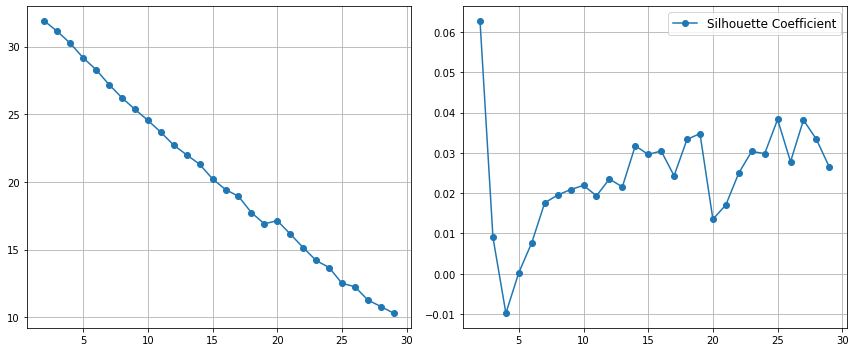

In [20]:
# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [21]:
k_means = KMeans(n_clusters=20, random_state=42)

pivot_df['label'] = k_means.fit_predict(train_data)

In [22]:
# PCA for dimension reduction
pca = PCA(n_components=2, random_state=42)
pivot_df['x'] = pca.fit_transform(train_data)[:, 0]
pivot_df['y'] = pca.fit_transform(train_data)[:, 1]

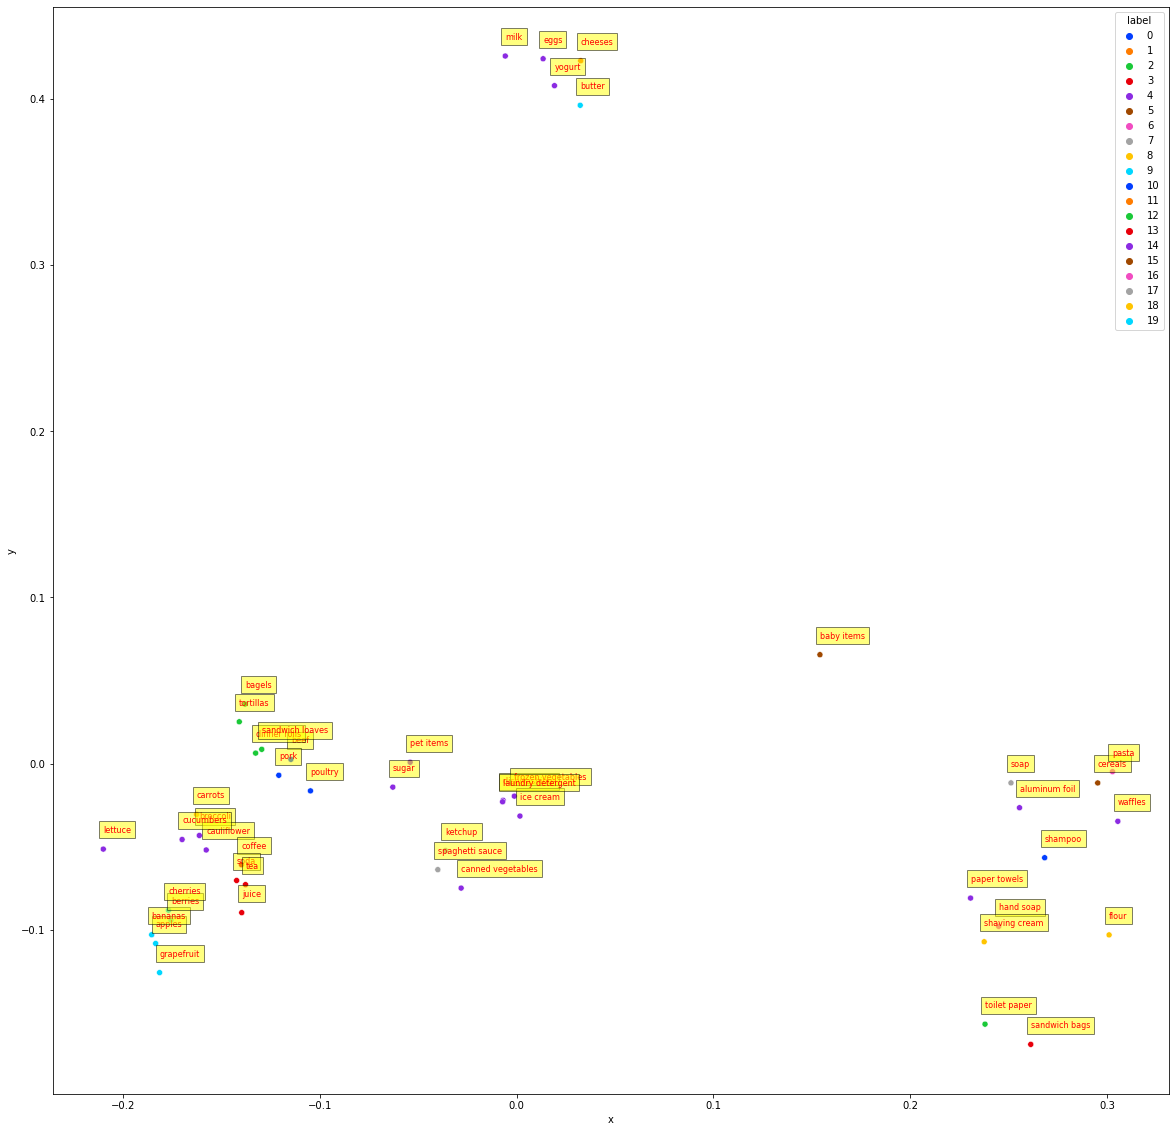

In [23]:
result = pivot_df[['x', 'y', 'label']].reset_index()
fig, ax = plt.subplots(figsize = (20, 20))
sns.scatterplot(data = result, x = 'x', y = 'y', hue = 'label', palette="bright")

for i in range(result.shape[0]):
    plt.text(x=result.x[i],y=result.y[i]+0.01,s=result.Item_name[i], 
          fontdict=dict(color='red',size=8),
          bbox=dict(facecolor='yellow',alpha=0.5))

In [24]:
temp = result.groupby(['label'])['Item_name'].agg(', '.join).reset_index()
temp

,label,Item_name
0,0,"beef, pork, poultry"
1,1,carrots
2,2,"bagels, dinner rolls, sandwich loaves, tortillas"
3,3,"coffee, juice, soda, tea"
4,4,"aluminum foil, broccoli, canned vegetables, ca..."
5,5,cereals
6,6,pasta
7,7,soap
8,8,flour
9,9,"apples, bananas, berries, cherries, grapefruit"
